# Quality control, Pre-Processing and Taxonomic profiling of Whole Metagenome Shotgun Sequencing (WMS-S) data with MetaSnake

Author: Monica R. Ticlla Ccenhua <br>
e-mail: mticlla@gmail.com monicaroxana.ticllaccenhua@unibas.ch

**Summary**

Whole-metagenome shotgun (WMS) reads were processed with an in-house analysis pipeline that performs quality pre-processing, taxonomic profiling, and functional profiling. Quality pre-processing included adapter/quality trimming, and filtering with \textit{fastp} <cite data-cite="2542765/87J2X2T7"></cite>;  removal of reads derived from human DNA with BBTools' _bbsplit_ <cite data-cite="2542765/ITPM2QC7"></cite>; and removal of duplicated reads with BBTools' _clumpify_. Taxonomic profiling was performed with _MetaPhlAn2_ <cite data-cite="2542765/8LC3DVWH"></cite>. The pipeline is available at https://git.scicore.unibas.ch/TBRU/MetagenomicSnake. For  each  species  detected, we  obtained the  reported  mode  of  metabolism  (i.e  oxygen  requirement)  by manually  querying https://bacdive.dsmz.de, https://www.lgcstandards-atcc.org/, https://microbewiki.kenyon.edu/, http://www.homd.org, and  PubmedCentral®(PMC); the resulting table is available at https://git.scicore.unibas.ch/TBRU/tbdar-microbiome-cases/-/blob/master/data/raw/metadata/species_oxygen_tolerance.csv.

In [1]:
report_date = %env REPORT_DATE
print(report_date)

2020-07-14


## 0. Set-up working environment

**Set-up working directory**

In [2]:
%%capture
cd ../

**Import python modules**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc

**Create additional directories**

In [4]:
#

## 1. Processing with MetaSnk

**Configuration file**

MetaSnk needs a configuration file. We used the one below:

In [5]:
%%bash
cat $PWD/config/metasnk_config.yaml

# This file should contain everything to configure the workflow on a global scale.
# In case of sample based data, it should be complemented by a samples.tsv file that contains
# one row per sample. It can be parsed easily via pandas.

# Set PATHS
# WARNING:
#   MetagenomicSnake uses singularity containers to run the workflow.
#   Bind access to those paths if needed
#   Singularity's --bind/-B option can be specified multiple times,
#   or a comma-delimited string of bind path specifications can be used.
#

# Absolute PATH to folder where to find fastq files
RAW_DIR: "PWD+'/data/raw/wms'"
# Absolute PATH to folder where to place output files
OUT_DIR: "PWD+'/data/interim/MetaSnk'"

#
SAMPLE_UNITS:
  auto: true
#-------------------------------------------------------------------------------
# Modules
#-------------------------------------------------------------------------------
rawQC:
  samplerate: 0.1

preprocess:
  trim_adapters:
    adapter: 'CTGTCTCTTATACACATCT'
    min_length: 50

**Quality check of raw fastq files**

The code below is a dry run, it only shows what will be executed. Remove option -n for an actual execution.

In [6]:
%%bash --err error
source $HOME/.bashrc
conda activate MetaSnk && snakemake \
    --snakefile $metasnk/Snakefile \
    --configfile $PWD/config/metasnk_config.yaml \
    --directory ./data/interim \
    --profile $metasnk/profiles/slurm \
    --cluster-config $metasnk/slurm_cluster.json \
    -n rawQC | head -n 10

Building DAG of jobs...
Job counts:
	count	jobs
	469	fastqc_raw
	1	multiqc_raw
	1	multiqc_raw_list_files
	1	rawQC
	1	summarize_raw
	473



**Quality pre-processing of raw fastq files**

The code below is a dry run, it only shows what will be executed. Remove option -n for an actual execution.

In [7]:
%%bash --err error
source $HOME/.bashrc
conda activate MetaSnk && snakemake \
    --snakefile $metasnk/Snakefile \
    --configfile $PWD/config/metasnk_config.yaml \
    --directory ./data/interim \
    --profile $metasnk/profiles/slurm \
    --cluster-config $metasnk/slurm_cluster.json \
    -n preQC | head -n 10

Building DAG of jobs...
Job counts:
	count	jobs
	1	check_concatenation
	129	concatenate_fastqs
	469	dedupe
	469	filter_human
	1	mqc_filter_human
	1	mqc_filter_human_list_files
	1	mqc_trim_3end_list_files


**Taxonomic profiling with MetaPhlAn2**

The code below is a dry run, it only shows what will be executed. Remove option -n for an actual execution.

In [8]:
%%bash --err error
source $HOME/.bashrc
conda activate MetaSnk && snakemake \
    --snakefile $metasnk/Snakefile \
    --configfile $PWD/config/metasnk_config.yaml \
    --directory ./data/interim \
    --profile $metasnk/profiles/slurm \
    --cluster-config $metasnk/slurm_cluster.json \
    -n MetaPhlAn2 | head -n 10

Building DAG of jobs...
Job counts:
	count	jobs
	1	MetaPhlAn2
	129	concatenate_fastqs
	469	dedupe
	469	filter_human
	1	metaphlan2_merge
	129	metaphlan2_profile
	1	metaphlan2_visualize


## 2. Visualize results

**Summary of pre-processing with MetaSnk rawQC**

In [9]:
per_sample_summary_file = 'data/interim/MetaSnk/wms_cases/preQC/summary_stats/wms_cases_preqc_samples_summary.tsv'
per_sample_summary = pd.read_csv(per_sample_summary_file, sep='\t', header=0, index_col=None)
per_sample_summary.head()

Sample  total_reads  trim_adapters_disc_reads  filter_human_disc_reads  \
0  M00001      71814.0                    9522.0                    12828   
1  M00002   42527990.0                 1190726.0                 32207562   
2  M00004     155690.0                   10772.0                    38802   
3  M00007   27962484.0                  649470.0                 22442806   
4  M00011   16844976.0                  367340.0                 14306560   

   dedupe_disc_reads  trim_3end_disc_reads  total_disc_reads  \
0                4.0                   6.0           22360.0   
1          1582038.0                 404.0        34980730.0   
2            26080.0                   6.0           75660.0   
3           691374.0                 312.0        23783962.0   
4           164658.0                 146.0        14838704.0   

   total_kept_reads  trim_adapters_pct_disc  filter_human_pct_disc  \
0           49454.0               13.424153              18.252013   
1         7547260.0                2.797835              75.750155   
2           80030.0                6.891739              24.885185   
3         4178522.0                2.320865              80.274212   
4         2006272.0                2.175891              84.956609   

   dedupe_pct_disc  trim_3end_pct_disc  total_pct_disc  total_pct_kept  
0         0.004728            0.007116       31.688011       68.311989  
1         3.719520            0.000945       82.268455       17.731545  
2        16.918639            0.003873       48.699436       51.300564  
3         2.473234            0.001114       85.069425       14.930575  
4         0.975577            0.000866       88.108944       11.891056

In [10]:
per_sample_summary.loc[per_sample_summary.Sample == 'M00130',]

Sample  total_reads  trim_adapters_disc_reads  filter_human_disc_reads  \
60  M00130     634618.0                   51444.0                   378310   

    dedupe_disc_reads  trim_3end_disc_reads  total_disc_reads  \
60              792.0                 138.0          430684.0   

    total_kept_reads  trim_adapters_pct_disc  filter_human_pct_disc  \
60          203934.0                8.108746              59.618071   

    dedupe_pct_disc  trim_3end_pct_disc  total_pct_disc  total_pct_kept  
60         0.124128            0.021795       67.872739       32.127261

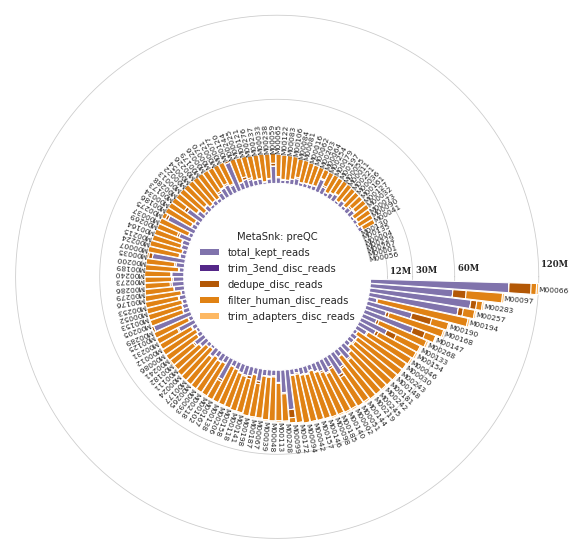

In [11]:
# Plot summary as a radial bar chart
def plot_preqc_summary(preqc_summary_df, by='units', plot_type='raw'):
    """Creates a radial bar chart from the dataframe generted by summarize_preqc.
    
    Args:
        preqc_summary_df: pd.DataFrame object generated by summarize_preqc()
        by: either 'units' or 'samples'. it specifies how to aggregate the data.
        plot_type: either 'raw' or 'pct'. If 'pct' a percent stacked barchar is returned.
    Returns:
        matplotlib.figure.Figure
    """
    import inspect
    by_options = ['units','samples']
    type_options = ['raw','pct']
    
    frame = inspect.currentframe()
    args_type = ['pandas.DataFrame', by_options, type_options]
    UNDEFINED = object()
    def print_message(frame, args_type):
        args, _, _, values = inspect.getargvalues(frame)
        print('{}()'.format(inspect.getframeinfo(frame)[2]))
        print('Args:')
        for ix,arg in enumerate(args):
            print('    {}: {}'.format(arg, str(args_type[ix])))
    
    if (not isinstance(preqc_summary_df, pd.DataFrame)) or (by not in by_options) or (plot_type not in type_options):
        print('Invalid arguments')
        print_message(frame,args_type)
        return(UNDEFINED)
    else:
        try:
            if plot_type == 'raw':
                columns_to_plot = ['trim_adapters_disc_reads',
                                   'filter_human_disc_reads', 
                                   'dedupe_disc_reads',
                                   'trim_3end_disc_reads',
                                   'total_kept_reads']
                sample_run_lane = preqc_summary_df[['total_reads','Sample']+columns_to_plot].copy()
                if by == 'samples':
                    sample_run_lane = sample_run_lane.groupby(['Sample']).agg('sum')
                bottom_lim = 0.0
                top_lim = sample_run_lane['total_reads'].max()
                # This uses the given y-units of bottom spacing for each bar
                # You may increase this number a bit to have more spacing between bars and text.
                bottom_spacing = top_lim/1.8
                rgrids_positions = [sample_run_lane['total_reads'].max()/(i) for i in [10,4,2,1]] + bottom_spacing
                rgrids_positions_labels = [' {0:.{1}f}M'.format(nr,0) 
                                           for ix,nr in enumerate(np.round((rgrids_positions-bottom_spacing)/1000000, decimals=3))]
            else:
                columns_to_plot = ['trim_adapters_pct_disc',
                                   'filter_human_pct_disc', 
                                   'dedupe_pct_disc',
                                   'trim_3end_pct_disc',
                                   'total_pct_kept']
                sample_run_lane = preqc_summary_df[['total_reads','Sample']+columns_to_plot].copy()
                if by == 'samples':
                    sample_run_lane = sample_run_lane.groupby(['Sample']).agg('mean')
                bottom_lim = 0.0
                top_lim = 100
                bottom_spacing = top_lim/1.8
                rgrids_values = [25,50,75,100]
                rgrids_positions =  np.add(rgrids_values,bottom_spacing)
                rgrids_positions_labels = [' {0:.{1}f}%'.format(nr,0) for nr in rgrids_values]
                    
            sample_run_lane.sort_values(by=['total_reads'], inplace=True)
            # Colors for each column (nested bars inside each bar)
            barColors = ['#fdb863', '#e08214', '#b35806', '#542788','#8073ac'][::-1]
        except (TypeError, ValueError) as e:
            print(e)
        else:
            # This variable was used for testing purposes to see how fold increases 
            # of the datapoints affects the plot
            lenMult = 1
            # Nr of datapoints to plot
            nr_h_bars = len(sample_run_lane)*lenMult
            # This sets the number of x-positions left empty at the beginning
            # so that enough space is left for y-labels
            nr_empty_bars = np.int(np.ceil(nr_h_bars/40))
            empty_bars = [0]*nr_empty_bars
            empty_bars_labels = ['']*len(empty_bars)
            # re-set the number of x-positions (data points) to plot
            nr_h_bars = nr_h_bars+nr_empty_bars
    
            # The positions of the bars on the x-axis
            # Each position corresponds to a radian degree in a unit circunference (radius is 1)
            # The circumference (2pi) is divided into nr_h_bars sections
            r= np.arange(0,2*np.pi,2*np.pi/nr_h_bars) # for radial barchart 
            r= r[0:nr_h_bars]
            # Bar width
            barWidth = (2*np.pi)/(nr_h_bars)*0.9 # for radial barchart 
    
            # Define the columns to use for the stacked bars, 
            # values of each column are plot on top of one another
            barColumns = columns_to_plot[::-1]
    
            # This uses the given y-units of bottom spacing for each bar
            # You may increase this number a bit to have more spacing between bars and text.
            bottomBars = [bottom_spacing]*nr_h_bars
    
            # Lets set the figure size depending on the amount of data points to plot
            # Labels until 1000 datapoints are readable
            # Consider adding additional elif scenarios to increase size for larger datasets
            if nr_h_bars <=200:
                fig = plt.figure(figsize=(10, 10))
                font_size = 7.5
            elif nr_h_bars <= 500:
                fig = plt.figure(figsize=(20, 20))
                font_size = 'x-small'
            else:
                fig = plt.figure(figsize=(28, 28))
                font_size = 6

            # Here we do the actual plotting
            # ------------------------------
            # Values for each column for a datapoint (i.e sequencing unit, or sample)
            # are plot on top of one another
            ax = fig.add_axes([0.1,0.1,0.75,0.75], projection='polar')
            for ix,column in enumerate(barColumns):
                bar_values=empty_bars+sample_run_lane[column].tolist()*lenMult
                bars=ax.bar(r, bar_values, bottom=bottomBars, 
                            color=barColors[ix], edgecolor='white', width=barWidth, label=column)
                bottomBars = np.add(bottomBars,bar_values).tolist()
    
            # Here we add annotations (e.g labels, legend)
            # --------------------------------------------
            rotations = np.rad2deg(r)
            y0,y1 = ax.get_ylim()
            bar_labels= empty_bars_labels + sample_run_lane.index.tolist()*lenMult
            for x, y_pos, rotation, label in zip(r, bottomBars, rotations, bar_labels):
                offset = (y_pos)/(y1-y0)
                lab = ax.text(0, 0, label, fontsize=font_size, transform=None, ha='center', va='center', fontstretch='ultra-condensed')
                renderer = ax.figure.canvas.get_renderer()
                bbox = lab.get_window_extent(renderer=renderer)
                invb = ax.transData.inverted().transform([[0,0],[bbox.width,0] ])
                lab.set_position((x,offset+(invb[1][0]-invb[0][0])/2.*2.7) )
                lab.set_transform(ax.get_xaxis_transform())
                lab.set_rotation(rotation)
            #rgrids_positions = sample_run_lane['total_reads'].describe()[[3,5,7]].values + bottom_spacing
            #rgrids_positions_labels = [' {}M'.format(nr)
            #                           for ix,nr in enumerate(np.round((rgrids_positions-bottom_spacing)/1000000, decimals=3))]
            ax.set_rgrids(rgrids_positions,
                          labels=rgrids_positions_labels, 
                          angle=np.rad2deg(r[np.int(nr_empty_bars/2-1)]), 
                          family='serif', ha='left', va='center', weight='bold',fontstretch='ultra-condensed', fontsize=8.5)
            ax.legend(bbox_to_anchor=(0.5, 0.5), loc='center', frameon=False, title='MetaSnk: preQC')
            # A few extra edits for aesthetics
            # -------------------------------
            ax.xaxis.grid(False)
            ax.spines["polar"].set_visible(False)
            ax.set_xticklabels([])
    
            return(fig,ax)

samples_summary_preqc_plot_file = 'reports/figures/WMS-S_MetaSnk-preQC_counts.svg'
with plt.style.context('seaborn-whitegrid'):
    my_dpi=80
    fig1,ax1 = plot_preqc_summary(per_sample_summary, by='samples',plot_type='raw')
    fig1.savefig(samples_summary_preqc_plot_file, bbox_inches='tight', format='svg', dpi=my_dpi)

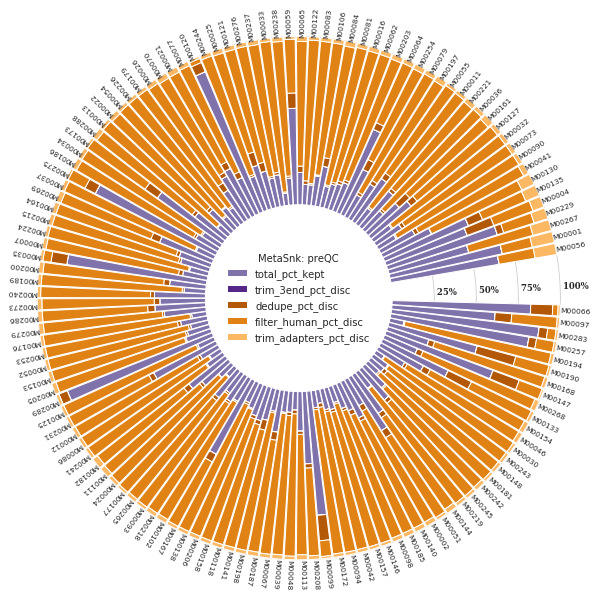

In [12]:
samples_summary_preqc_pct_plot_file = 'reports/figures/WMS-S_MetaSnk-preQC_pct.svg'
with plt.style.context('seaborn-whitegrid'):
    my_dpi=80
    fig2,ax2 = plot_preqc_summary(per_sample_summary, by='samples',plot_type='pct')
    fig2.savefig(samples_summary_preqc_pct_plot_file, bbox_inches='tight', format='svg', dpi=my_dpi)

## References

<div class="cite2c-biblio"></div>